In [1]:
# Libraries

import argparse
import os
import platform
import itertools
import ray
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tuner

ray.init(include_dashboard = False)

from ray.tune import choice
from ray.tune import uniform
from ray.tune import loguniform
from ray.tune import randint
from ray.tune import grid_search

2023-06-02 15:43:22,381	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
# Code

from source.python.raytune import raytune_data
from source.python.raytune import raytune_model
from source.python.raytune import raytune_plot
from source.python.raytune import raytune_utils
from source.python.raytune import raytune_feature
from source.python.io      import loader
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [5]:
# Define output and inputs

TUNER_CONCURRENT = 1
TUNER_TRIALS     = 5
TUNER_GRACE      = 5
TUNER_NOTEBOOK   = True
TUNER_SEARCH     = 'gridsearch'
MODEL_EPOCHS     = 10
GENERATOR        = 'group'

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)

	_split_generators = ['stratified', 'group', 'random']

	parser.add_argument('--tuner_concurrent', type = int, default = 5)
	parser.add_argument('--tuner_trials',     type = int, default = 500)
	parser.add_argument('--tuner_grace',      type = int, default = 10)
	parser.add_argument('--model_epochs',     type = int, default = 50)
	parser.add_argument('--generator',        type = str, default = 'group', choices = _split_generators)

	args = vars(parser.parse_args())

	TUNER_CONCURRENT = args['tuner_concurrent']
	TUNER_TRIALS     = args['tuner_trials']
	TUNER_GRACE      = args['tuner_grace']
	MODEL_EPOCHS     = args['model_epochs']
	GENERATOR        = args['generator']

	TUNER_NOTEBOOK   = False

Running as .ipynb



In [7]:
# Setup some directory paths.

SUBFOLDER = os.path.join('nbp06-tuner', 'feature')

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      SUBFOLDER)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\feature
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\feature\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner



In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 16.149 GB



# 2. Tuner

In [9]:
# Define basic data parameters

CONFIG = {
	'core/device'             : DEVICE,
	'core/outdir'             : OUT_DATA,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/subfolder'          : SUBFOLDER,
	'dataset/expanddim'       : None,
	'dataset/split/generator' : GENERATOR,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/epochs'            : MODEL_EPOCHS,
	'model/input/features'    : 72,
	'model/mode'              : 'regression',
	'model/output/size'       : 1,
	'model/type'              : 'r',
	'params/filepath'         : RES_TUNER,
	'params/tuner'            : None,
	'plot/trials'             : 3,
	'tuner/checkpoint'        : False,
	'tuner/max_concurrent'    : TUNER_CONCURRENT,
	'tuner/max_epochs'        : MODEL_EPOCHS,
	'tuner/min_epochs'        : TUNER_GRACE,
	'tuner/reporter/freq'     : 30,
	'tuner/reporter/notebook' : TUNER_NOTEBOOK,
	'tuner/search'            : 'gridsearch',
	'tuner/stopper'           : True,
	'tuner/stopper/days'      : 3,
	'tuner/stopper/hours'     : 22,
	'tuner/stopper/minutes'   : 0,
	'tuner/trials'            : TUNER_TRIALS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

# 3. Search Space

In [10]:
# Define optimizer parameters

optimizer_name     = 'adam'
optimizer_lr       = loguniform(1e-6, 1e-3)
optimizer_decay    = uniform(0.000, 0.100)
optimizer_beta1    = uniform(0.600, 0.950)
optimizer_beta2    = uniform(0.950, 0.999)

In [11]:
# Define scheduler parameters

scheduler_name       = 'exponential'
scheduler_exp_factor = uniform(0.900, 0.995)

In [12]:
# Define criterion parameters

criterion_name      = 'mse'
criterion_reduction = 'mean'

In [13]:
# Define model parameters

model_dropout   = uniform(0.0, 0.5)
model_leakyrelu = uniform(0.0, 0.1)

fc1_features = [64, 128, 256, 512]
fc2_features = [64, 128, 256, 512]

In [14]:
# Grid Search

gs_model = [
	'densefc2',
	'densefc3'
]

gs_filter = [
	'filter1', #          all -          longest transcript per gene
	'filter2', #          all - maximum mean tpm transcript per gene
	'filter3', #          tpm - average tpm > 5
	'filter4', # perturbation - control + unstressed
	'filter5'  #       strand - positive
]

gs_target = [
	'global-mean'
]

In [15]:
# Define search space

param_space = dict()

# Dataset
param_space['dataset/batch_size'] = choice([32, 64, 128])

# Optimizer
param_space['optimizer/name']  = optimizer_name
param_space['optimizer/lr']    = optimizer_lr
param_space['optimizer/decay'] = optimizer_decay
param_space['optimizer/beta1'] = optimizer_beta1
param_space['optimizer/beta2'] = optimizer_beta2

# Criterion
param_space['criterion/name']      = criterion_name
param_space['criterion/reduction'] = criterion_reduction

# Scheduler
param_space['scheduler/name']               = scheduler_name
param_space['scheduler/exponential/factor'] = scheduler_exp_factor

# Model
param_space['model/dropout']   = model_dropout
param_space['model/leakyrelu'] = model_leakyrelu

# Linear
param_space['model/fc1/features'] = choice(fc1_features)
param_space['model/fc2/features'] = choice(fc2_features)

# Grid Search
param_space['gs/model']   = grid_search(gs_model)
param_space['gs/filter']  = grid_search(gs_filter)
param_space['gs/target']  = grid_search(gs_target)

# 4. Tuning

In [16]:
# Create tuner config

trainable = raytune_utils.create_trainable(
	method    = raytune_feature.main,
	config    = CONFIG,
	cpu_count = SYSTEM['platform/cpu/count'],
	gpu_count = SYSTEM['platform/gpu/count']
)

tune_config = raytune_utils.create_tune_config(
	config    = CONFIG,
	algorithm = CONFIG['tuner/search'],
	params    = None
)

run_config = raytune_utils.create_run_config(
	config    = CONFIG,
	local_dir = OUT_DATA,
	verbosity = raytune_utils.VERBOSE_STATUS,
	task      = 'feature'
)

In [17]:
# Create tune and fit

tuner = raytune_utils.create_tuner(
	trainable   = trainable,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-06-02 16:12:53,917	INFO tune.py:762 -- Total run time: 1764.57 seconds (1764.31 seconds for the tuning loop).


# 5. Reports

In [18]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
	print()
else :
	print('No errors.')
	print()

No errors.



In [19]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

print()
print()

valid_loss                               valid_r2                                 valid_mae                                
valid_mape                               valid_wmape                              train_loss                               
train_r2                                 train_mae                                train_mape                               
train_wmape                              lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_sin

In [20]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

if CONFIG['model/mode'] == 'regression' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1'
	]]

trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      0.2 minutes
 Longest training time :      1.0 minutes
   Total training time :     25.0 minutes
    Mean training time :      0.5 minutes



,trial_id,logdir,time_total_s,training_iteration,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
2,3897d_00002,C:\Developer\Workspace\PyCharm\Projects\upolan...,38.446,10,0.510,-0.157,0.566,0.357,0.256,0.416,0.061,0.507,0.354,0.230
7,3897d_00007,C:\Developer\Workspace\PyCharm\Projects\upolan...,40.144,10,0.475,-0.080,0.546,0.348,0.247,0.417,0.062,0.507,0.360,0.230
1,3897d_00001,C:\Developer\Workspace\PyCharm\Projects\upolan...,56.078,10,0.812,-0.003,0.742,1.770,0.419,0.756,0.072,0.713,1.936,0.398
6,3897d_00006,C:\Developer\Workspace\PyCharm\Projects\upolan...,57.187,10,0.795,0.026,0.736,1.775,0.415,0.759,0.075,0.717,1.877,0.399
9,3897d_00009,C:\Developer\Workspace\PyCharm\Projects\upolan...,19.401,5,0.885,-0.096,0.771,1.910,0.433,0.763,0.068,0.725,1.854,0.411
8,3897d_00008,C:\Developer\Workspace\PyCharm\Projects\upolan...,42.208,5,0.827,-0.011,0.748,1.684,0.421,0.771,0.060,0.725,1.753,0.402
3,3897d_00003,C:\Developer\Workspace\PyCharm\Projects\upolan...,39.988,5,0.862,-0.054,0.765,1.689,0.430,0.771,0.063,0.720,1.813,0.400
5,3897d_00005,C:\Developer\Workspace\PyCharm\Projects\upolan...,38.523,5,0.854,-0.022,0.767,1.925,0.446,0.776,0.049,0.736,1.991,0.435
0,3897d_00000,C:\Developer\Workspace\PyCharm\Projects\upolan...,51.834,10,0.852,-0.022,0.767,1.934,0.446,0.777,0.057,0.736,1.960,0.433
4,3897d_00004,C:\Developer\Workspace\PyCharm\Projects\upolan...,17.323,5,0.895,-0.105,0.776,1.875,0.436,0.787,0.051,0.737,1.853,0.418


In [21]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, 'report.csv')
)

## 5.1 Visualization

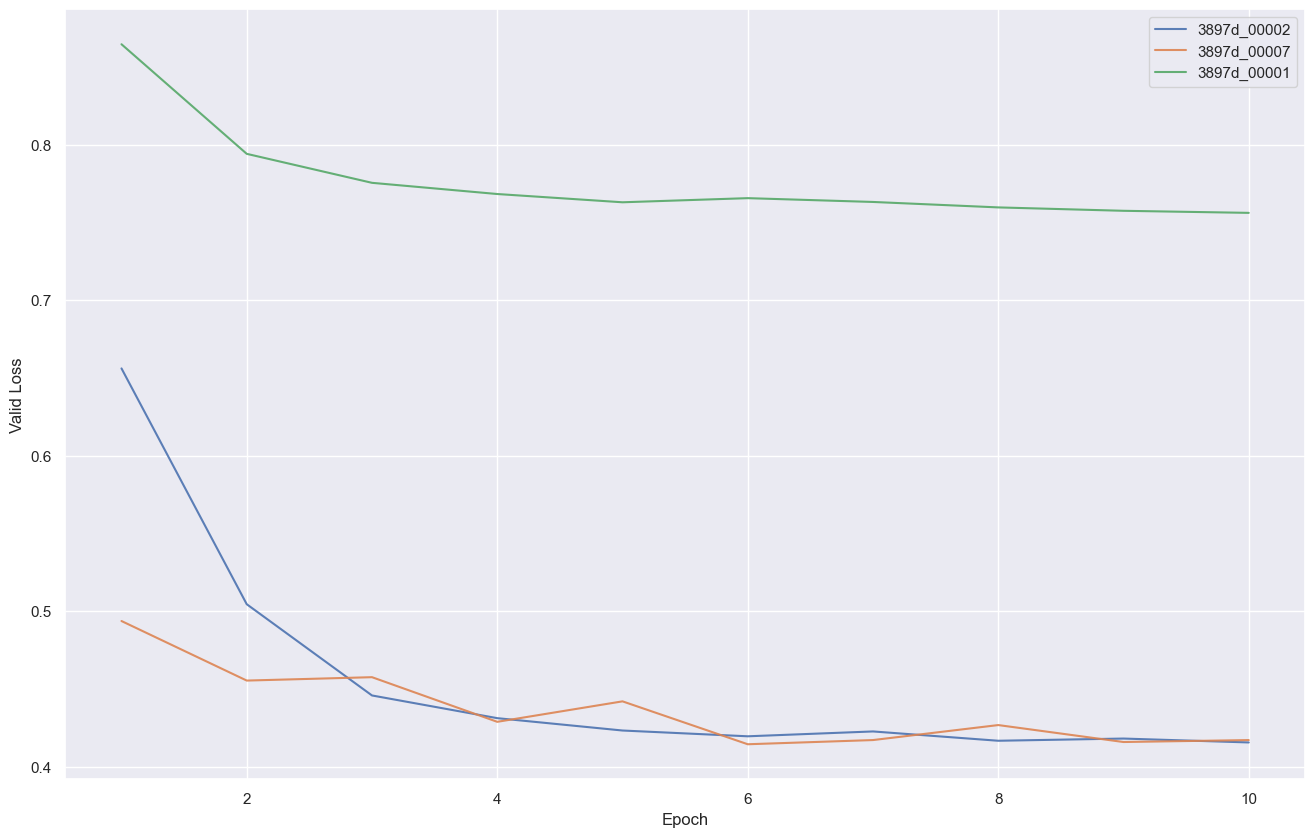

In [22]:
# Plot trials valid loss

raytune_plot.trials_lineplot_loss(
	dataframe  = trials,
	max_trials = CONFIG['plot/trials'],
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

### 5.1.1 Regression

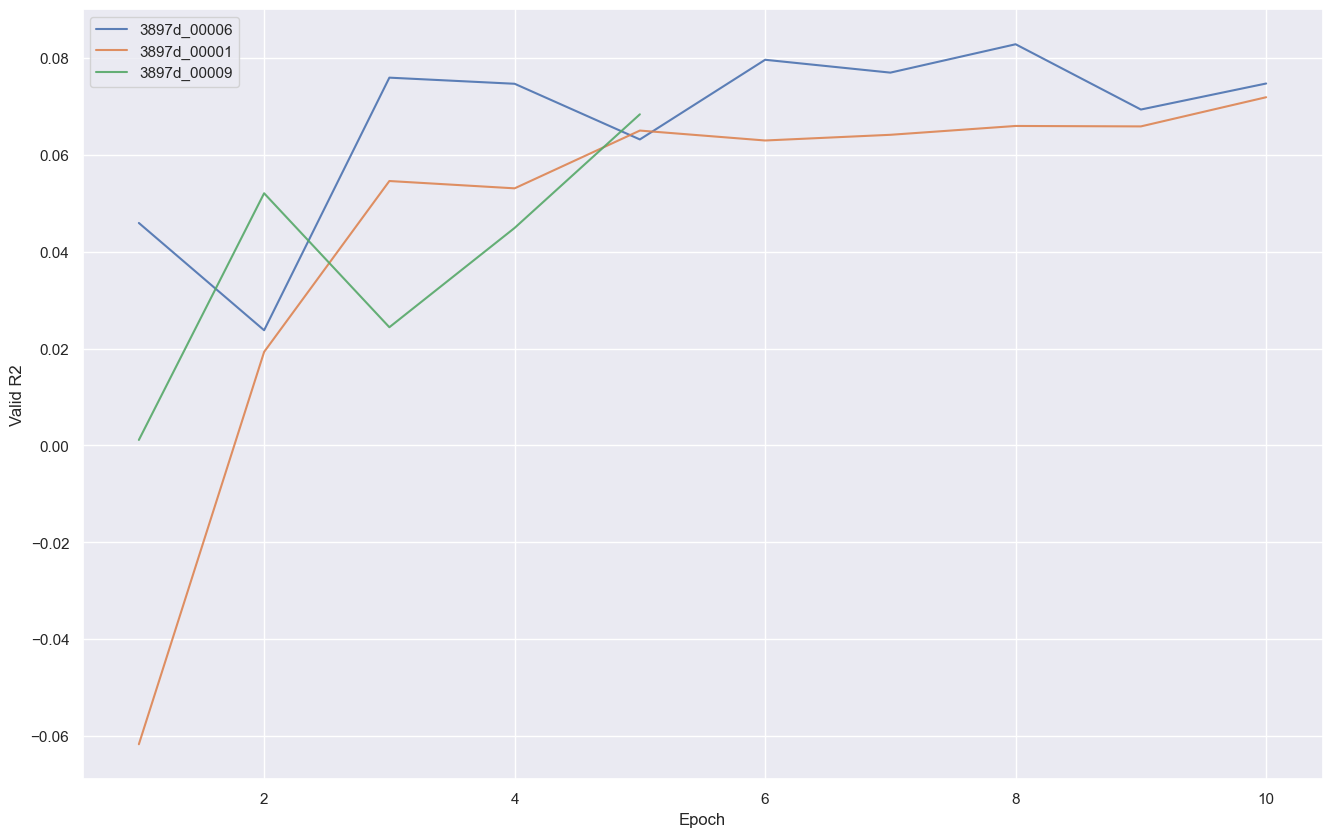

In [23]:
# Plot trials valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_lineplot_r2(
		dataframe  = trials,
		max_trials = CONFIG['plot/trials'],
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

### 5.1.2 Classification

In [24]:
# Plot trials valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_lineplot_accuracy(
		dataframe  = trials,
		max_trials = CONFIG['plot/trials'],
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

## 5.2 Best

In [25]:
# Display best trial

best = report.get_best_result()

if CONFIG['model/mode'] == 'regression'     : metrics = ['loss', 'r2', 'mae', 'mape', 'wmape']
if CONFIG['model/mode'] == 'classification' : metrics = ['loss', 'accuracy', 'auroc', 'f1', 'matthews']

for mode, metric in itertools.product(['train', 'valid'], metrics) :
	k0 = 'metrics/{}/{}'.format(mode, metric)
	k1 = '{}_{}'.format(mode, metric)

	best.config[k0] = float(best.metrics[k1])

print('Best config :')
print()
print('{')

for index, (key, val) in enumerate(sorted(best.config.items()), start = 1) :
	if isinstance(key, str)   : key = f'"{key}"'
	if isinstance(val, str)   : val = f'"{val}"'

	if isinstance(val, float) : print('\t{:30s} : {:.16f}'.format(key, val), end = '')
	else                      : print('\t{:30s} : {}'.format(key, val), end = '')

	if index < len(best.config) : print(',')
	else                        : print('')

print('}')
print()

Best config :

{
	"criterion/name"               : "mse",
	"criterion/reduction"          : "mean",
	"dataset/batch_size"           : 32,
	"gs/filter"                    : "filter3",
	"gs/model"                     : "densefc2",
	"gs/target"                    : "global-mean",
	"metrics/train/loss"           : 0.5097579608230041,
	"metrics/train/mae"            : 0.5659607813481710,
	"metrics/train/mape"           : 0.3565940260887146,
	"metrics/train/r2"             : -0.1565403342247009,
	"metrics/train/wmape"          : 0.2556112110614777,
	"metrics/valid/loss"           : 0.4156306555162240,
	"metrics/valid/mae"            : 0.5066690099301195,
	"metrics/valid/mape"           : 0.3542558550834656,
	"metrics/valid/r2"             : 0.0606948696076870,
	"metrics/valid/wmape"          : 0.2300714701414108,
	"model/dropout"                : 0.4716237574848844,
	"model/fc1/features"           : 128,
	"model/fc2/features"           : 512,
	"model/leakyrelu"              : 0.0745639816374

In [26]:
# Display per iteration

progress = loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

if CONFIG['model/mode'] == 'regression' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1', 'train_matthews',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1', 'valid_matthews'
	]]

progress

,trial_id,time_total_s,training_iteration,lr,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
0,3897d_00002,20.314,1,0.000,2.094,-3.885,1.178,0.543,0.531,0.656,-0.518,0.634,0.370,0.288
1,3897d_00002,22.082,2,0.000,0.732,-0.689,0.672,0.385,0.303,0.504,-0.173,0.559,0.355,0.254
2,3897d_00002,23.874,3,0.000,0.625,-0.449,0.623,0.369,0.281,0.446,-0.026,0.526,0.352,0.239
3,3897d_00002,25.991,4,0.000,0.568,-0.303,0.594,0.361,0.269,0.431,0.022,0.517,0.353,0.235
4,3897d_00002,28.023,5,0.000,0.545,-0.248,0.585,0.358,0.264,0.423,0.038,0.512,0.355,0.233
5,3897d_00002,30.122,6,0.000,0.544,-0.237,0.585,0.362,0.264,0.420,0.053,0.509,0.353,0.231
6,3897d_00002,32.169,7,0.000,0.528,-0.210,0.576,0.360,0.260,0.423,0.040,0.511,0.353,0.232
7,3897d_00002,34.216,8,0.000,0.521,-0.186,0.570,0.354,0.258,0.417,0.049,0.508,0.353,0.230
8,3897d_00002,36.286,9,0.000,0.517,-0.182,0.564,0.354,0.255,0.418,0.047,0.508,0.356,0.231
9,3897d_00002,38.446,10,0.000,0.510,-0.157,0.566,0.357,0.256,0.416,0.061,0.507,0.354,0.230


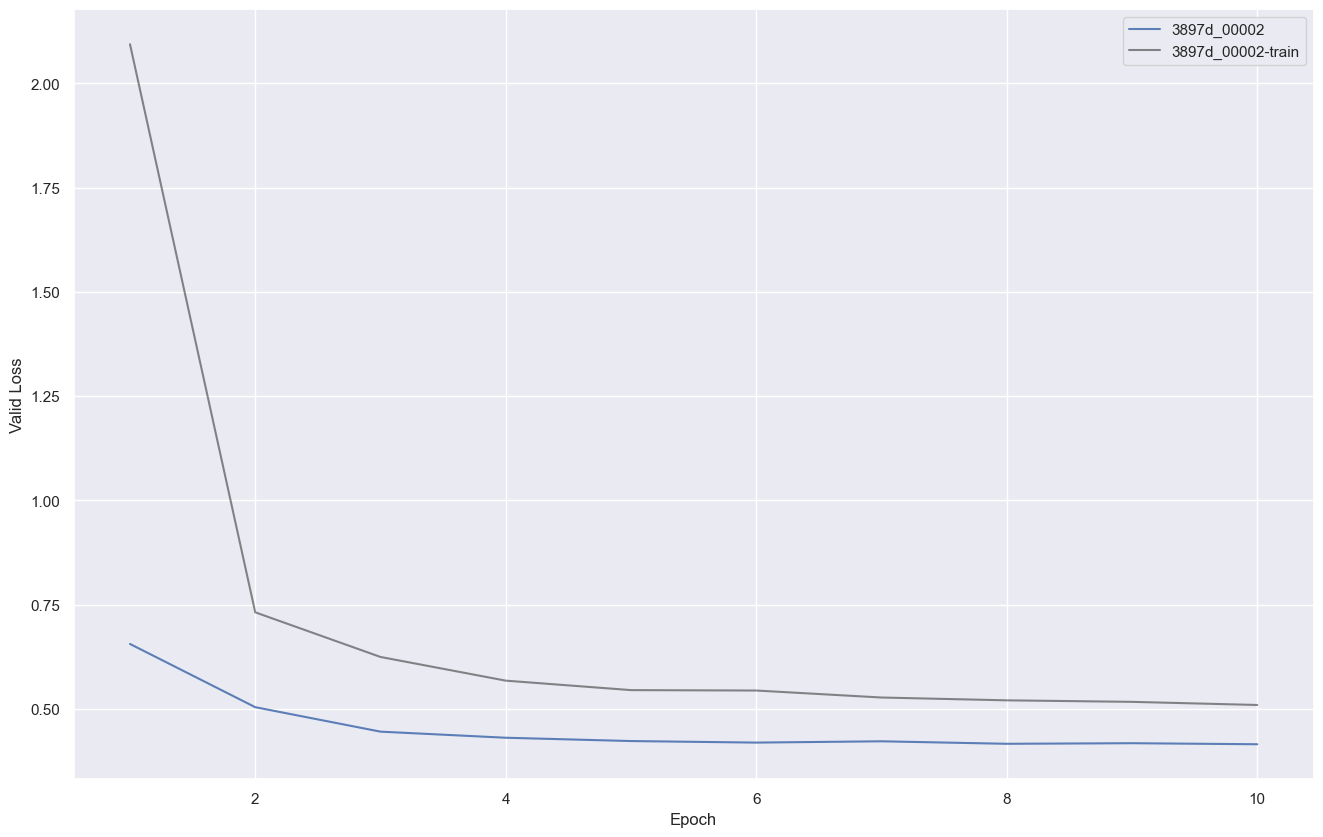

In [27]:
# Plot best trial valid loss

raytune_plot.trial_lineplot_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

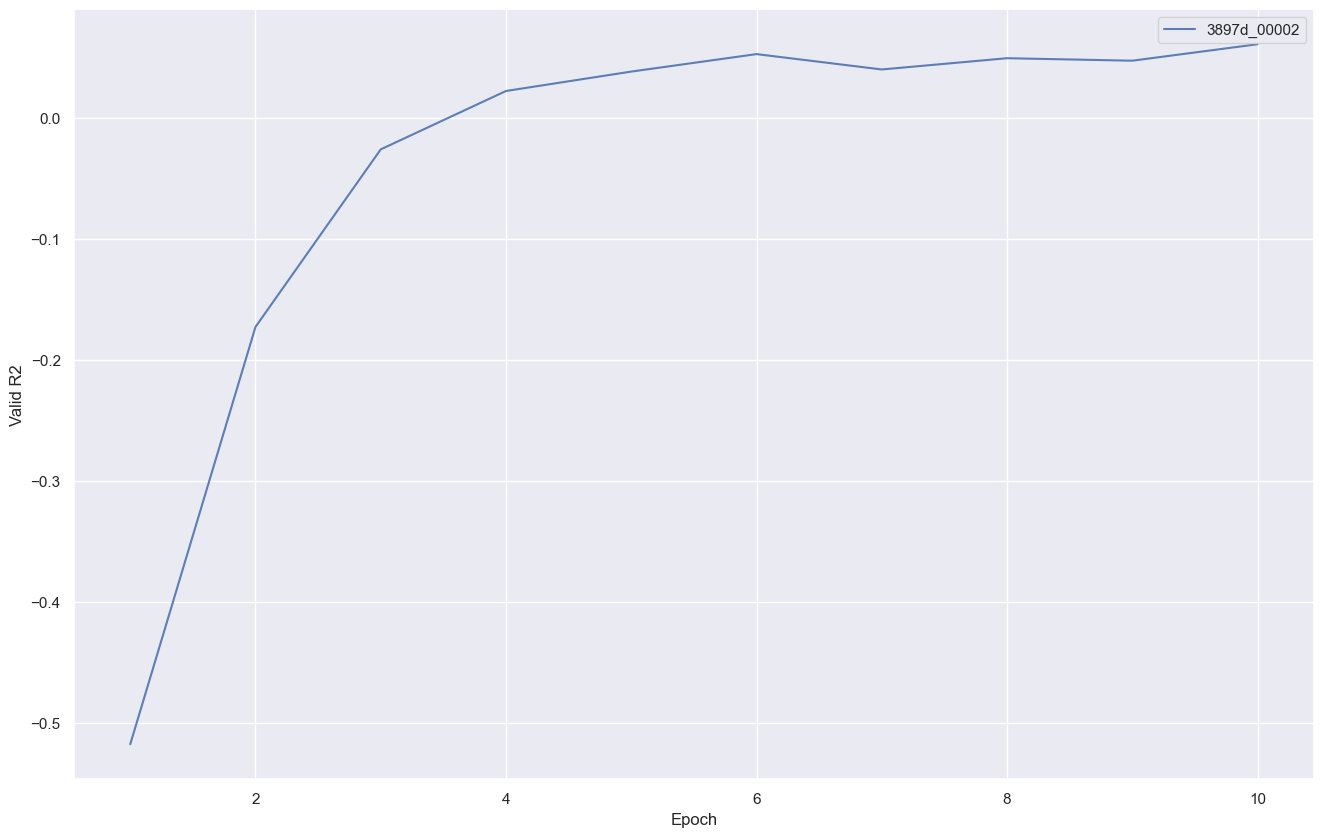

In [28]:
# Plot best trial valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trial_lineplot_r2(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

In [29]:
# Plot best trial valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trial_lineplot_accuracy(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

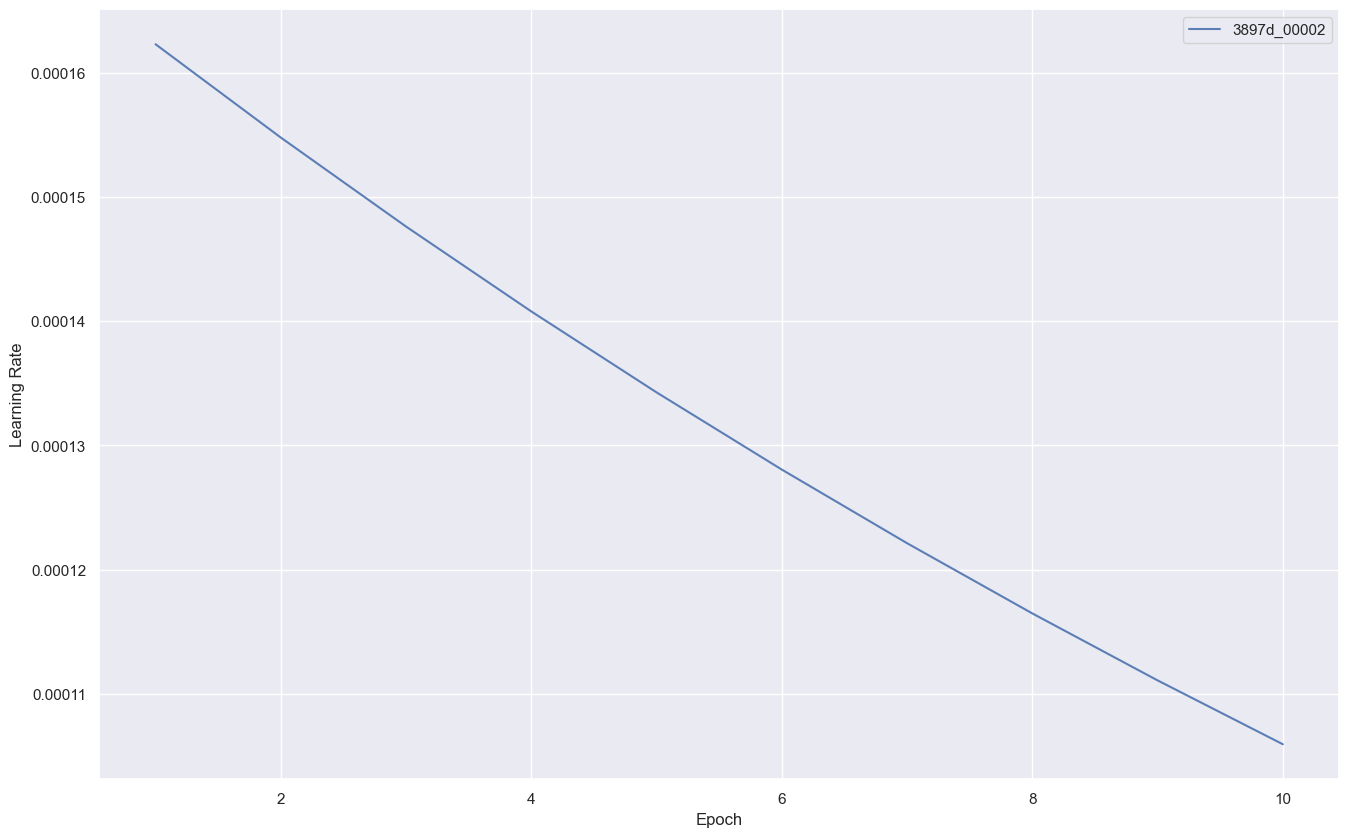

In [30]:
# Plot trials learning rate

raytune_plot.trial_lineplot_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)